In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

### Boosting

#### Adaboost

In [29]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)

# X, yを作成
# X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')] 
# 後ほどXに対して更新をおこうなう際に，Viewに対して代入処理をするとSettingWithCopyWarningが発生するため，.dropを使用する
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']

# ラベルエンコーディング
oe = OrdinalEncoder()
# 出力結果をDataFrameにする．NumPyArrayだと後続の処理でエラーになることが多い
oe.set_output(transform='pandas') # sklearnが古い場合は!pip install --upgrade scikit-learnで更新
# デフォルトではうまくカテゴリカル変数のみをターゲットにしてくれないので，カテゴリカル変数に対してのみ処理をするようにする
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [30]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

adaboost AUC: 0.9375


[0.   0.   0.02 0.   0.   0.07 0.   0.   0.29 0.62 0.   0.   0.  ]


<BarContainer object of 13 artists>

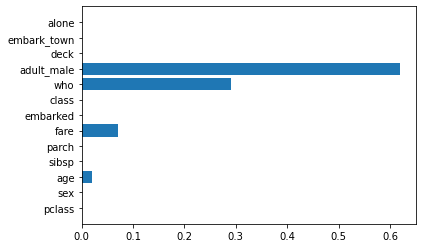

In [31]:
# 特徴量重要度
print(ada.feature_importances_)
plt.barh(X.columns, ada.feature_importances_)

### gradient boosting 回帰

### スクラッチで実装

In [35]:
class MyGradientBoostingRegressor:

    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []

    def fit(self, X, y):
        # 初期モデルF0をyの平均値とする
        self.F0 = y.mean()
        Fb = self.F0
        
        # 決定木をn_estimators回学習
        for _ in range(self.n_estimators):
            # 誤差の算出
            r = y - Fb
            # 決定木の学習
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r)
            weight = estimator.predict(X)

            # Fbを更新
            Fb += self.learning_rate * weight
            # 決定木をリストに追加
            self.estimators.append(estimator)
            
    def predict(self, X):
        # 初期モデルF0から始める
        Fb = self.F0
        # 各決定木f1 ~ fbまでの予測値を加算して最終的な予測値を計算
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)

        return Fb

<AxesSubplot:xlabel='mpg', ylabel='horsepower'>

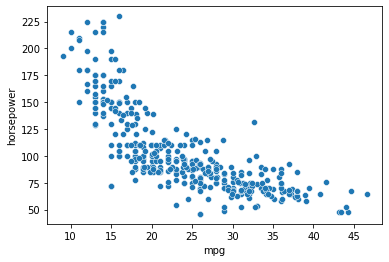

In [33]:
# データ準備
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
X = df['horsepower'].values.reshape(-1, 1)
y = df['mpg'].values
sns.scatterplot(x=df['mpg'], y=df['horsepower'])

In [36]:
my_gbr = MyGradientBoostingRegressor()
my_gbr.fit(X, y)
my_gbr.predict(X)

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 23.01512881,
       23.01512881, 22.21547999, 24.54754893, 24.54754893, 31.96655862,
       24.54754893, 24.54754893, 23.01512881, 20.76151767, 24.54754893,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 24.54754893,
       24.54754893, 23.01512881, 20.76151767, 20.76151767, 20.76151767,
       24.54754893, 20.76151767, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 20.76151767,
       27.71424635, 20.76151767, 24.54754893, 24.54754893, 24.54754893,
       31.61939691, 27.71424635, 31.96655862, 31.61939691, 31.96655862,
       31.61939691, 23.01512881, 27.71424635, 31.96655862, 24.54754893,
       24.54754893, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74

### sklearnのGradientBoostingRegressorを使う

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

# インスタンス生成
gbr = GradientBoostingRegressor(learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0)

# 学習
gbr.fit(X, y)

# 予測
y_pred = gbr.predict(X)

In [38]:
y_pred

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 23.01512881,
       23.01512881, 22.21547999, 24.54754893, 24.54754893, 31.96655862,
       24.54754893, 24.54754893, 23.01512881, 20.76151767, 24.54754893,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 24.54754893,
       24.54754893, 23.01512881, 20.76151767, 20.76151767, 20.76151767,
       24.54754893, 20.76151767, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 20.76151767,
       27.71424635, 20.76151767, 24.54754893, 24.54754893, 24.54754893,
       31.61939691, 27.71424635, 31.96655862, 31.61939691, 31.96655862,
       31.61939691, 23.01512881, 27.71424635, 31.96655862, 24.54754893,
       24.54754893, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74

In [39]:
my_gbr.predict(X) == gbr.predict(X)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,